<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Random-stuff" data-toc-modified-id="Random-stuff-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Random stuff</a></span></li><li><span><a href="#Workflow" data-toc-modified-id="Workflow-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Workflow</a></span><ul class="toc-item"><li><span><a href="#Reading-layers" data-toc-modified-id="Reading-layers-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Reading layers</a></span></li><li><span><a href="#EASE-grid-v2" data-toc-modified-id="EASE-grid-v2-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>EASE grid v2</a></span></li><li><span><a href="#Translate-tables-to-multidimensional-spatial-format" data-toc-modified-id="Translate-tables-to-multidimensional-spatial-format-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Translate tables to multidimensional spatial format</a></span></li><li><span><a href="#Node-class" data-toc-modified-id="Node-class-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Node class</a></span></li><li><span><a href="#Layer-parser" data-toc-modified-id="Layer-parser-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Layer parser</a></span></li></ul></li><li><span><a href="#Get-application-layer-&amp;-data" data-toc-modified-id="Get-application-layer-&amp;-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get application layer &amp; data</a></span></li><li><span><a href="#Check-new-grid-functionality" data-toc-modified-id="Check-new-grid-functionality-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check new grid functionality</a></span><ul class="toc-item"><li><span><a href="#Grid-style" data-toc-modified-id="Grid-style-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Grid style</a></span></li><li><span><a href="#Folium-map" data-toc-modified-id="Folium-map-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Folium map</a></span></li></ul></li></ul></div>

*note: TOC above will not work in GitHub notebook viewer*

# Aggregate of ORNL DAAC Soil Moisture Visualizer outputs

Import modules and authenticate with URS:

In [1]:
# import modules
import os
import json
import warnings
from io import StringIO
from datetime import datetime

import branca
import folium
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from shapely.geometry import shape
from folium.plugins import MiniMap

# for saving/loading example xr.Dataset
try:                             # <- Python 3
    import _pickle as pickle
except ModuleNotFoundError:      # <- Python 2
    import pickle

# force Earthdata login
from ursjupyter import *

'Login successful. Download with: session.get(url)'

## Random stuff

In [2]:
disabled_sources =  ["FLUXNET", "MODIS", "GRACE", "PBOH2O"]

smvdownload = "https://airmoss.ornl.gov/cgi-bin/viz/api/download.pl?"
smvdatasets = pd.read_csv(
    "docs/smvdatasets.csv", 
    index_col="dataset", 
    header=0)

download_msg = """<p style="text-align:center;">Click <b>Submit</b> to downloa
d Soil Moisture Visualizer data for this site.<br></p>"""

numvalid = lambda v: np.count_nonzero(~np.isnan(v.data))
allnan = lambda v: numvalid(v)==0

node_header = ["id", "lat", "lon", "node"]
layer_header = ["id", "lat", "lon", "layer", "nodes", "points", "xr"]

## Workflow

### Reading layers

In [3]:
def get_colors(n, cmap=cm.Set2):
    """ 
    Takes integer count of colors to map and optional kwarg: 
      'cmap=matplotlib.cm.<cmap>'.
    """

    cspace = np.linspace(0.0, 1.0, n)           # *1
    rgb = cmap(cspace)                          # *2
    cols = [colors.to_hex(c[0:3]) for c in rgb] # *3

    return(cols)

def from_geojson(input_geojson):
    """ """
    
    with open(input_geojson, "r") as f:
        shapes = json.load(f)
    features = shapes["features"]
    
    return(features)

Read the geojson file and print the first feature's properties:

In [4]:
shapes = "docs/usfs_sites/Sites_lf_geo.json"
features = from_geojson(shapes)                   # get features and cols

features[1]["properties"]

{'OBJECTID': 62,
 'RANGERDIST': '99030503010343',
 'REGION': '03',
 'FORESTNUMB': '05',
 'DISTRICTNU': '03',
 'DISTRICTOR': '030503',
 'FORESTNAME': 'Coronado National Forest',
 'DISTRICTNA': 'Sierra Vista Ranger District',
 'GIS_ACRES': 321534.997,
 'SHAPE_Leng': 2.85406639797,
 'SHAPE_Area': 0.12353517012,
 'Rowid_': 60,
 'FID_1': 61,
 'COUNT': 7331,
 'AREA': 458187500,
 'MIN': -83,
 'MAX': 40,
 'RANGE': 123,
 'MEAN': -54.0062747238,
 'STD': 13.1775267796,
 'SUM': -395920,
 'VARIETY': 97,
 'MAJORITY': -54,
 'MINORITY': -6,
 'MEDIAN': -55,
 'Count_1': 7457,
 'Count_2': 7219,
 'Count_3': 7228,
 'Count_4': 7223,
 'Count_5': 7226,
 'Count_6': 7225,
 'Count_7': 7229,
 'Count_8': 7226,
 'Count_9': 7229,
 'Count_10': 7229,
 'Count_11': 7225,
 'Count_12': 7229,
 'Count_13': 7229,
 'Count_14': 7218,
 'Count_15': 7229,
 'Count_16': 7224,
 'Count_17': 7205,
 'Count_18': 7464,
 'Count_19': 7468,
 'Count_20': 7466,
 'Count_21': 7460,
 'Count_22': 7464,
 'Count_23': 7460,
 'Count_24': 7454,
 'Coun

Plot geojson:

In [5]:
import folium
from IPython.display import display
from ipywidgets import Layout, HBox, VBox, HTML

b = ('https://server.arcgisonline.com/ArcGIS/rest/'
     'services/World_Imagery/MapServer/tile/{z}/{y}/{x}')
c = [shape(features[1]["geometry"]).centroid.y,
     shape(features[1]["geometry"]).centroid.x]

m = folium.Map(
    tiles=b,
    location=c,
    zoom_start=9,
    control_scale=True,
    prefer_canvas=True,  
    attr='Basemap by ESRI')

cols = get_colors(len(features))
sfunc = lambda feature: {'fillColor':'blue','color':'white','weight': 0.75}
hfunc = lambda feature: {'fillColor':'white','color':'black','weight': 1.5}
styles = {
    'style_function': sfunc,
    'highlight_function': hfunc}

folium.GeoJson(features[1], **styles).add_to(m)

m

### EASE grid v2

In [6]:
latf = "docs/EASE2_M09km.lats.3856x1624x1.double"
lonf = "docs/EASE2_M09km.lons.3856x1624x1.double"

lats = np.fromfile(latf, dtype=np.float64).flatten() 
lons = np.fromfile(lonf, dtype=np.float64).flatten()

crds = np.dstack((lats,lons))[0]
crds.shape

(6262144, 2)

Get ease grid points:

In [7]:
def get_ease(shapely_geom):
    """ """

    bnds = shapely_geom.bounds 
    ease = crds[
        (bnds[1]<lats) & (lats<bnds[3]) &     # ybnds < lat < ybnds
        (bnds[0]<lons) & (lons<bnds[2])]      # xbnds < lon < xbnds
    
    ease_table = {"id":[],"lat":[],"lon":[],"tup":[],"in":[]}
    for i, p in enumerate(ease):
        ease_table["id"].append(i)
        ease_table["lat"].append(p[0])
        ease_table["lon"].append(p[1])
        ease_table["tup"].append((p[0], p[1]))
        shplypt = shape({"type":"Point","coordinates":(p[1], p[0])})
        shpin = True if shapely_geom.contains(shplypt) else False
        ease_table["in"].append(shpin)
        
    return(pd.DataFrame(ease_table))


shply = shape(features[1]["geometry"])
ease = get_ease(shply)

ease.head(10)

,id,lat,lon,tup,in
0,0,31.914396,-110.772822,"(31.914395558957498, -110.77282157676346)",False
1,1,31.914396,-110.679461,"(31.914395558957498, -110.67946058091285)",False
2,2,31.914396,-110.586100,"(31.914395558957498, -110.58609958506221)",False
3,3,31.914396,-110.492739,"(31.914395558957498, -110.4927385892116)",False
4,4,31.914396,-110.399378,"(31.914395558957498, -110.39937759336097)",False
5,5,31.914396,-110.306017,"(31.914395558957498, -110.30601659751036)",False
6,6,31.831558,-110.772822,"(31.83155788300685, -110.77282157676346)",False
7,7,31.831558,-110.679461,"(31.83155788300685, -110.67946058091285)",False
8,8,31.831558,-110.586100,"(31.83155788300685, -110.58609958506221)",False
9,9,31.831558,-110.492739,"(31.83155788300685, -110.4927385892116)",False


Map some points:

In [8]:
for ix, row in ease.iterrows():  
    
    pop = " ".join([
        str(ix),
        str(row["lat"]),
        str(row["lon"])])
    
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=7,
        weight=1,
        popup=pop,
        color="white",
        fill=True,
        fill_color="gray"
    ).add_to(m)

m

### Translate tables to multidimensional spatial format

In [9]:
def txt_to_pd(response_text):
    """Parses response.text to data frame with date index."""
    
    f = StringIO(response_text)                      # get file from string

    df = pd.read_csv(
        f, 
        header=4, 
        index_col="time",
        error_bad_lines=False, 
        warn_bad_lines=False)                        # read to df
    df.index = pd.to_datetime(df.index)              # convert index to dates
    
    return(df)


def split_pd(col):
    """Splits pd column by ; and set all values to float, nan."""
    
    df = col.str.split(";",n=2,expand=True)           # split col by ;
    df = df.replace('', np.nan)                       # set '' to nan
    df = df.astype(float)                             # set all to float
    df.columns = ["Min","Mean","Max"]                 # add column names
    
    return(df)


def pd_to_xr(dataset, df):
    """Makes an xr.Dataset from a pandas column (series) and coords."""

    a = smvdatasets.loc[dataset].to_dict()
    x = xr.DataArray(df, name=dataset, attrs=a)
    x = x.rename(dict(dim_1="stat"))
    
    return(x)


def get_coords(node):
    """ """

    n = xr.DataArray(data=[node.id], dims=["node"])
    
    y = xr.DataArray(data=[node.lat], coords=[n], dims=["node"], attrs=dict(
        standard_name="latitude",
        long_name="latitude coordinate",
        units="degrees_north"))
    
    x = xr.DataArray(data=[node.lon], coords=[n], dims=["node"], attrs=dict(
        standard_name="latitude",
        long_name="latitude",
        units="degrees_north"))
    
    return(y, x)


def get_node_xr(node, grid=True):
    """ """
        
    node.submit(session) # download the data
    df = node.df                                         # get the sample df
    
    ds = {}
    for dataset in df.columns:
        a = smvdatasets.loc[dataset].to_dict()
        if a["source"] not in disabled_sources:
            split_column = split_pd(df[dataset])
            ds[dataset] = pd_to_xr(dataset, split_column)
    
    node.grid = grid
    y, x = get_coords(node)
    xds = xr.merge(ds.values())                          # merge to one xr
    xds = xds.assign_coords(lat=y, lon=x)                # add coord arrays
        
    return(xds)

### Node class

In [10]:
class Node(object):
    """ """

    off = {"fill_opacity": 0.4, "stroke": False}
    
    def __init__(self, i, lat, lon):
        """Inits with id,lat,lon; makes request string, map point."""
        
        self.id = i
        self.lat = lat 
        self.lon = lon
        self.on = False
        self.dl = smvdownload+"lt={0}&ln={1}&d=smap".format(lat, lon)
        
    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)

    def submit(self, session):
        """Called by parent. Downloads url. Updates status."""

        self.response = session.get(self.dl)
        self.df = txt_to_pd(self.response.text)            # read to
        self.on = True                                     # toggle status on

### Layer parser

In [11]:
def get_layer_data(i, feat, col="#FFFFFF", opac=0.4, samp=True):
    """ """

    shapely_geom = shape(feat["geometry"])              # shapely geom
    nodes = get_ease(shapely_geom) if samp else None    # ease grid points
    nodes["node"] = [Node(
        i, row["lat"], row["lon"]
    ) for i, row in nodes.iterrows()]
    nodes["xr"] = [None]*len(nodes.index)
    
    cent = shapely_geom.centroid                        # centroid
    lat, lon = cent.y, cent.x                           # lat, lon
    feat["properties"].update({"id": i, "style": {
        "weight": 0.75, 
        "color": "aliceblue",
        "fillColor": col,
        "fillOpacity": opac}})

    return((feat, lat, lon, nodes))


class Layer(object):
    """ """

    def __init__(self, i, feat, col=None, grid=True):
        """ """
        
        layer_data = get_layer_data(i, feat, col)
        
        self.id = i
        self.feat = layer_data[0]
        self.lat = layer_data[1]
        self.lon = layer_data[2]
        self.nodes = layer_data[3]
        self.grid = grid
        
        self.dl = False    # downloaded or nah?
        self.on = False    # toggle on or nah?

    def submit(self, session):
        """ """
        
        for i, node in self.nodes.iterrows():   # loop over sample pts
            if not node["node"].on:              
                self.nodes.at[i,"xr"] = get_node_xr(
                    node["node"], 
                    grid=self.grid)             # get xr dataset
        self.xr = xr.concat(self.nodes["xr"].tolist(), "node")
    
    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.layer, arg, val)
    
    def toxy(self):
        """ """    
        
        self.xr = self.xr.set_index({"node": ["lat", "lon"]})
        self.xr = self.xr.unstack()

## Get application layer & data

Running this cell will either:
* open the previously saved example dataset at `docs/feat1.pkl`, or
* request the data for feature1 if no pickled dataset exist in repo directory

In [12]:
try:
    with open('docs/feat1.pkl', 'rb') as output:
        poly = pickle.load(output)   # try to load binary file
except:
    poly = Layer(1, features[1])     # get Layer class       
    poly.submit(session)             # request all nodes
    with open('docs/feat1.pkl', 'wb') as output:
        pickle.dump(poly, output, -1)# dump to binary file

poly.xr

<xarray.Dataset>
Dimensions:                     (node: 48, stat: 3, time: 6240)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-05-01
  * stat                        (stat) object 'Min' 'Mean' 'Max'
  * node                        (node) int64 0 1 2 3 4 5 6 ... 42 43 44 45 46 47
    lat                         (node) float64 31.91 31.91 31.91 ... 31.34 31.34
    lon                         (node) float64 -110.8 -110.7 ... -110.4 -110.3
Data variables:
    SoilSCAPE_surface           (node, time, stat) float64 nan nan ... nan nan
    SoilSCAPE_rootzone          (node, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_surface        (node, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_rootzone       (node, time, stat) float64 nan nan ... nan nan
    AirMOSS_L4_rootzone         (node, time, stat) float64 nan nan ... nan nan
    SMAP_surface                (node, time, stat) float64 nan nan ... nan nan
    SMAP_rootzone             

## Check new grid functionality
Plot time series mean:

C:\Applications\Python\anaconda3_2\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Applications\Python\anaconda3_2\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


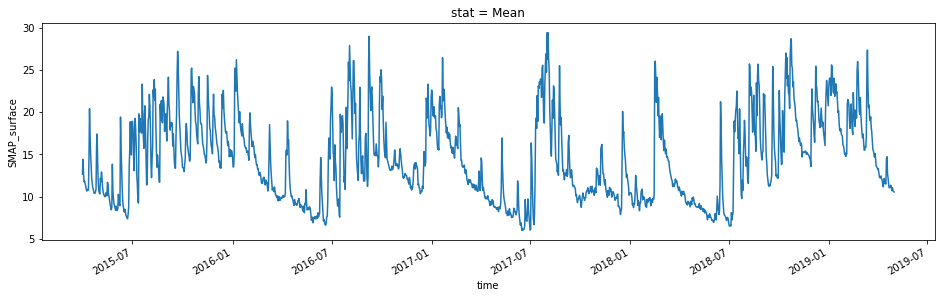

In [13]:
poly.xr["SMAP_surface"].sel(stat="Mean").mean("node").plot(x="time", figsize=(16, 4))

### Grid style
**The new Layer class method `Layer.toxy` converts the "node style" xarray object that we created for the USFS workshop to a "grid style":**

In [14]:
poly.toxy(); poly.xr

<xarray.Dataset>
Dimensions:                     (lat: 8, lon: 6, stat: 3, time: 6240)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-05-01
  * stat                        (stat) object 'Min' 'Mean' 'Max'
  * lat                         (lat) float64 31.34 31.42 31.5 ... 31.83 31.91
  * lon                         (lon) float64 -110.8 -110.7 ... -110.4 -110.3
Data variables:
    SoilSCAPE_surface           (time, stat, lat, lon) float64 nan nan ... nan
    SoilSCAPE_rootzone          (time, stat, lat, lon) float64 nan nan ... nan
    AirMOSS_L2_3_surface        (time, stat, lat, lon) float64 nan nan ... nan
    AirMOSS_L2_3_rootzone       (time, stat, lat, lon) float64 nan nan ... nan
    AirMOSS_L4_rootzone         (time, stat, lat, lon) float64 nan nan ... nan
    SMAP_surface                (time, stat, lat, lon) float64 nan nan ... 13.69
    SMAP_rootzone               (time, stat, lat, lon) float64 nan nan ... 25.57
    NEE_mean             

Now the same plotting function used above renders a gridded plot instead of a time series:

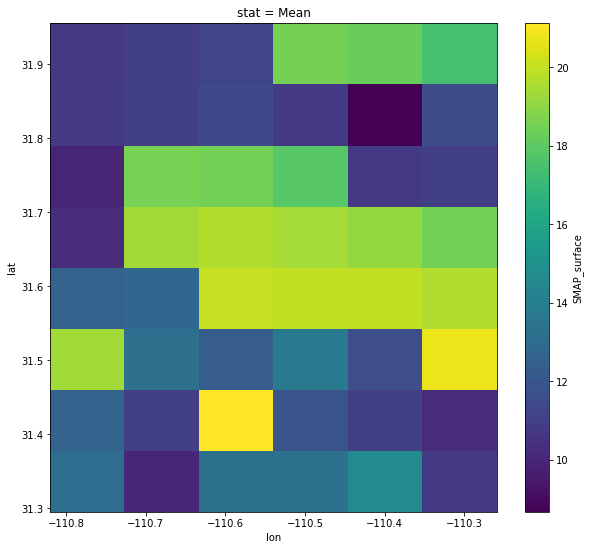

In [15]:
poly.xr["SMAP_surface"].sel(stat="Mean").mean("time").plot(figsize=(10,9))

### Folium map

This grid is the mean through all tim

In [16]:
# reset the map
m = folium.Map(
    tiles=b,
    location=c,
    zoom_start=9,
    control_scale=True,
    prefer_canvas=True,  
    attr='Basemap by ESRI')

# add the layer again
sfunc = lambda f: {'color':'black','weight': 0.75, 'fillOpacity': 0}
folium.GeoJson(features[1], style_function=sfunc).add_to(m)

# add a minimap
minimap = MiniMap(toggle_display=True)
m.add_child(minimap)

# get mean of time series
img = poly.xr["SMAP_surface"].sel(stat="Mean").mean("time").data

# make a colormap
cmap = branca.colormap.linear.viridis.scale(img.min(), img.max())
cmap.caption = 'Volumetric soil moisture (%; 0-5cm depth) from SMAP'
m.add_child(cmap)

# plot the raster
folium.raster_layers.ImageOverlay(
    image=img,
    bounds=[
        [poly.xr.lat.data.min() , poly.xr.lon.data.min()], 
        [poly.xr.lat.data.max() , poly.xr.lon.data.max()]],
    mercator_project=True,
    colormap=lambda x: cmap.rgb_bytes_tuple(x),
    opacity=0.5).add_to(m)

# layer controls
folium.LayerControl().add_to(m)

m

https://python-visualization.github.io/folium/modules.html#folium.raster_layers.ImageOverlay